In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyximport

import matplotlib.collections as mcoll

pyximport.install(setup_args={'include_dirs': np.get_include()},reload_support=True)
from RigidWallOverdampedLangevin3D_cython import RigidWallOverdampedLangevin3D 

from mpl_toolkits import mplot3d
from scipy.signal import correlate
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle

import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d
from scipy.signal import correlate

import time

import matplotlib as mpl
mpl.rcParams['figure.dpi']=140
mpl.rcParams['xtick.direction']="in"
mpl.rcParams['ytick.direction']="in"
mpl.rcParams['lines.markeredgecolor']="k"
mpl.rcParams['lines.markeredgewidth']=0.1
mpl.rcParams['lines.markersize'] = 10
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)

# Langevin 3D overdamped close rigid wall

<font color='blue'>
    We have that equation to compute : 

\begin{equation}
    x_i = x_{i-1} + ( - \Delta m g + R_{elec} + F_{correction} ) \frac{\Delta t}{\gamma (z)} + a(\gamma (z)) ~ dB_t ~ \Delta t
\end{equation}
    where:
\begin{equation}
    R_{elec} = \frac{4 k_b T}{l_d} exp( - \frac{z}{l_d})
\end{equation}
    and,
\begin{equation}
    F_{correction} = k_b T \frac{D_z'}{D_z} = k_b T \frac{42 R z^2 + 24 R^2z + 4R^2}{36 z^4 + 66Rz^3 + 30 R^2 z^2 + 4R^3 z}.
\end{equation}</font>
    
<font color='blue'>    
    $dB_t$ is a white noise like a gaussian law, with a average at zero and standard deviation at $\frac{1}{\Delta t}$. 
</font>

<font color='blue'>    
    $\gamma_x$ and $\gamma_y$ are compute with Libchaber paper formula and $\gamma_z$ with the Pade formula.
</font>


In [2]:
# tps1 = time.time()

langevin3D = RigidWallOverdampedLangevin3D(dt=1e-2, Nt=30000000, R=1.5e-6, rho=1050, x0=(0., 0., 1.5e-6))
langevin3D.trajectory()

# tps2 = time.time()

In [3]:
# print("Temps de calcul de la trajectoire : t = " + np.str(tps2 - tps1) + " s")

In [4]:
langevin3D.m/langevin3D.gamma

5.25e-07

In [5]:
# trajectories = langevin3D.x, langevin3D.y, langevin3D.z
# np.savetxt('Numerical_Trajectory_rigid_wall_langevin3D.txt', trajectories)

## 1. Trajectory

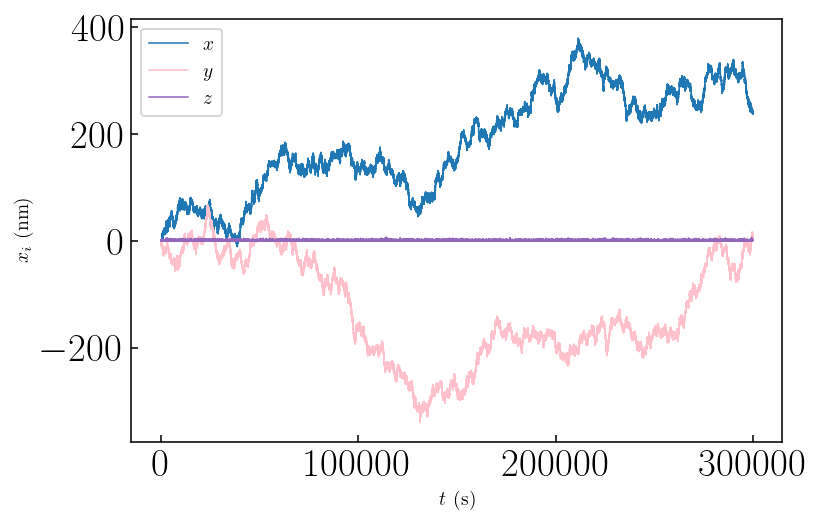

In [6]:
plt.plot(langevin3D.t,langevin3D.x/1e-6, "-", color="tab:blue", linewidth=0.8, label=r"$x$")
plt.plot(langevin3D.t,langevin3D.y/1e-6, "-", color="pink", linewidth=0.8, label=r"$y$")
plt.plot(langevin3D.t,langevin3D.z/1e-6, "-", color="tab:purple", linewidth=0.8, label=r"$z$")

plt.xlabel(r"$t~(\mathrm{s})$")
plt.ylabel(r"$x_i~(\mathrm{n m})$")

plt.legend()
plt.show()

## 2. Mean square displacement

In [7]:
MSDx, tau = langevin3D.MSD("x", space="wall", plot=False, output=True)

100%|███████████████████████████████████████████| 63/63 [00:04<00:00, 12.91it/s]


In [8]:
MSDy, tau = langevin3D.MSD("y", space="wall", plot=False, output=True)

100%|███████████████████████████████████████████| 63/63 [00:04<00:00, 13.35it/s]


In [9]:
MSDz, tau = langevin3D.MSD("z", space="wall", plot=False, output=True)

100%|███████████████████████████████████████████| 63/63 [00:04<00:00, 13.30it/s]


In [10]:
zth = np.linspace(1e-12, 10e-6, 1000)

Peq_z = langevin3D.P_z_wall(zth, 4.8)
Peq_z = Peq_z / np.trapz(Peq_z, zth)

D_parallele = langevin3D.kb*langevin3D.T/langevin3D._gamma_xy(zth)
D_perpendiculaire = langevin3D.kb*langevin3D.T/langevin3D._gamma_z(zth)

Dpara_mean = np.trapz(D_parallele * Peq_z, zth)
Dperp_mean = np.trapz(D_perpendiculaire * Peq_z, zth)

Tau_th = np.linspace(1e-3, 1e6, 100)

dz = np.linspace(-2.5e-5, 2.5e-5, 1000)
P_dz = langevin3D.P_deltaZ_longTime(dz, 4.8)
mean_dz_square = np.trapz(dz ** 2 * P_dz, dz)

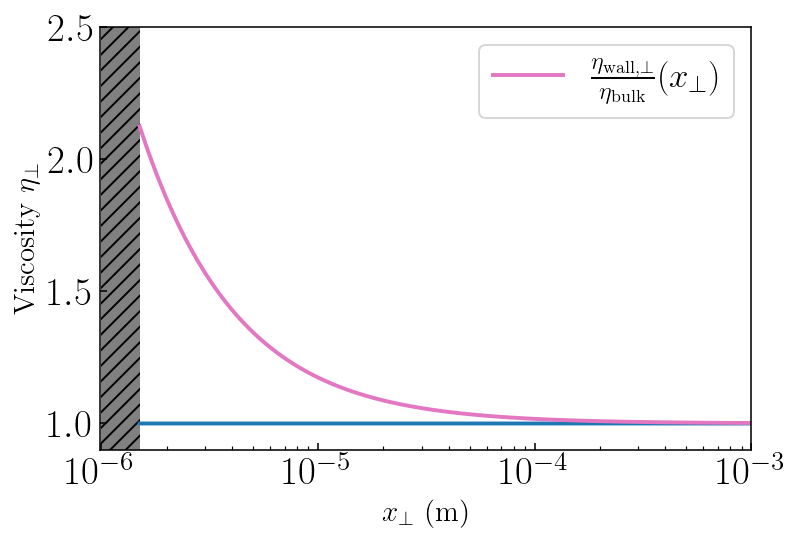

In [61]:
z_eta = np.linspace(langevin3D.R, 1e-3, 10000)

fig, ax = plt.subplots()

plt.plot(z_eta, np.ones(len(z_eta)), "-", color="tab:blue",linewidth=2)
plt.semilogx(z_eta, langevin3D._gamma_z(z_eta)/(6*np.pi*langevin3D.eta*langevin3D.R), "-", color="tab:pink",linewidth=2, label=r"$\frac{\eta_{\mathrm{wall}, \perp}}{\eta_{\mathrm{bulk}}}(x_\perp)$")

# plt.plot(np.ones(10)*1.5e-6, np.linspace(0, 2.25, 10), "k:", label=r"$\mathrm{particule~limite}$")
ax.add_patch(Rectangle((1e-6, 0.5), 0.5e-6, 4,facecolor = 'grey', hatch = '///', ))

ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


plt.xlabel(r"$x_\perp$ $(\mathrm{m})$", fontsize=15)
plt.ylabel(r"$\mathrm{Viscosity}~\eta_\perp$", fontsize=15)
plt.axis([9.9e-7, 1e-3, 0.9, 2.5])

plt.legend(fontsize=18)
# plt.show()
plt.savefig("Viscosity_z_RigidWall.png")

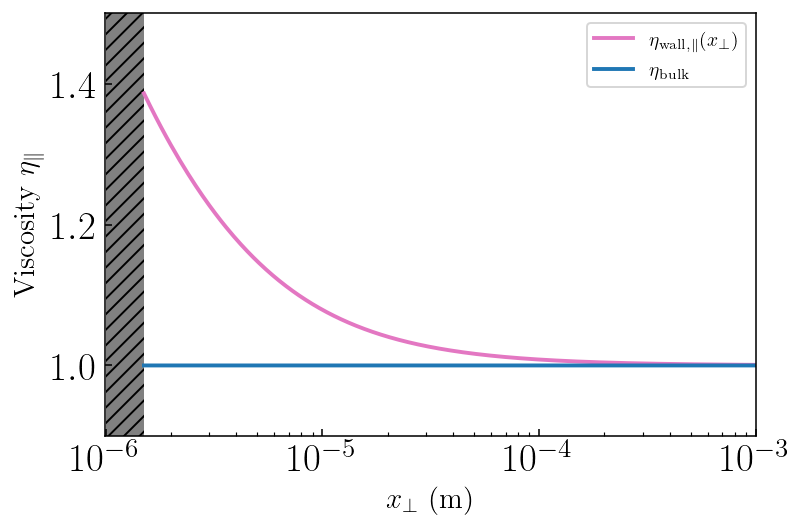

In [47]:
z_eta = np.linspace(langevin3D.R, 1e-3, 10000)

fig, ax = plt.subplots()

plt.semilogx(z_eta, langevin3D._gamma_xy(z_eta)/(6*np.pi*langevin3D.eta*langevin3D.R), "-", color="tab:pink",linewidth=2, label=r"$\eta_{\mathrm{wall}, \|}(x_\perp)$")
plt.plot(z_eta, np.ones(len(z_eta)), "-", color="tab:blue",linewidth=2,  label=r"$\eta_\mathrm{bulk}$")
# plt.plot(np.ones(10)*1.5e-6, np.linspace(0, 2.25, 10), "k:", label=r"$\mathrm{particule~limite}$")
ax.add_patch(Rectangle((1e-6, 0.5), 0.5e-6, 4,facecolor = 'grey', hatch = '///', ))

ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())


plt.xlabel(r"$x_\perp$ $(\mathrm{m})$", fontsize=15)
plt.ylabel(r"$\mathrm{Viscosity}~\eta_\|$", fontsize=15)
plt.axis([9.9e-7, 1e-3, 0.9, 1.5])

plt.legend()
# plt.show()
# plt.savefig("Viscosity_z_RigidWall.png")

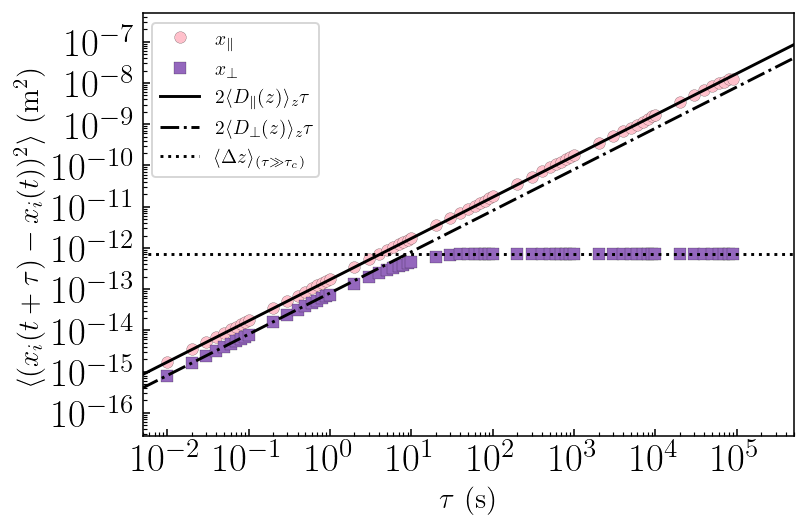

In [14]:
fig1 = plt.figure()
plt.loglog(tau,MSDx, "o", markersize=6, color="pink", label=r"$x_\|$",)
# plt.loglog(tau,MSDy,"^", markersize=10, color="pink", label=r"$x_\|$",)
plt.loglog(tau,MSDz,"s", markersize=6, color="tab:purple",label=r"$x_\perp$",)

plt.loglog(Tau_th, 2*Dpara_mean*Tau_th, "k-", label=r"$2 \langle D_{\|}(z) \rangle _z \tau$")
plt.loglog(Tau_th, 2*Dperp_mean*Tau_th, "k-.", label=r"$2 \langle D_{\perp}(z) \rangle _z \tau$")
plt.plot(Tau_th, mean_dz_square * np.ones(len(Tau_th)), "k:", label=r"$ \langle \Delta z \rangle_{(\tau \gg \tau_c)} $")


plt.xlabel(r"$\tau$ $(\mathrm{s})$", fontsize=15)
plt.ylabel(r"$\langle (x_i(t+\tau) - x_i(t))^2 \rangle$ $(\mathrm{m}^2)$", fontsize=15)
# plt.title("Mean square displacement at 1D.")

ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=100)
ax.xaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.axis([5e-3, 5e5, None, None])

plt.legend()
# plt.show()
# plt.savefig("MSD_rigidWall_overdamped.png")

## 3. Probability density function of z

<font color='blue'>    
    We compute the PDF of z trajectory and verify with the theory like :
</font>
<font color='blue'>  
    \begin{equation}
        P(z) = exp(- 4 ~ exp(- \frac{z}{l_d} ) - \frac{z}{l_b} ),
    \end{equation}
</font>
<font color='blue'>  
    with $l_b = \frac{k_b T}{\Delta m g}$ the Boltzmann lenght and $l_d$ the Debay lenght.
</font>

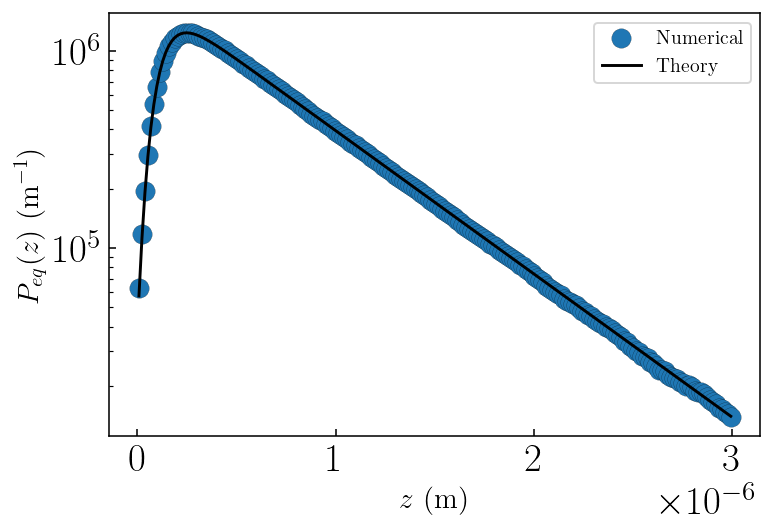

In [15]:
axis = "z"
bins = 200
hist, bin_edges = np.histogram(langevin3D.z[langevin3D.z < 3e-6], bins=bins, density=True)
binsPosition = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf = hist * 1/np.trapz(hist,binsPosition)

pdf_theo_brut = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
pdf_theo = pdf_theo_brut * 1/np.trapz(pdf_theo_brut,binsPosition) # normalised

plt.semilogy(binsPosition,pdf, "o", color="tab:blue", label=r"$\mathrm{Numerical}$")
plt.plot(binsPosition, pdf_theo, "k-", label=r"$\mathrm{Theory}$")

# plt.title("Probability density function of " + axis)
plt.xlabel(r"$z~(\mathrm{m})$", fontsize=15)
plt.ylabel(r"$P_{eq}(z)~(\mathrm{m}^{-1})$", fontsize=15)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend()
# plt.savefig("pdfz.pdf")


## 4. MSD in theory

## 4.1 Calculation of the MSDz plateau:

### 4.1.1) Calculation of P($\Delta$z)

<font color='blue'>    
    To compute the PDF of $\Delta z$ when $D_i$ is independant of $z$, we need to calculate :
    \begin{equation}
        P(\Delta z) = \int_{0}^{+\infty} P(z)~P(z+\Delta z)  \, \mathrm{d}z
    \end{equation}
    C'est la PDF($\Delta z$) au temps long avec un mur (je crois à verif).
</font>

In [16]:
def P_z(z, A, B, lD, lB):
    # PDF(z)
    if type(z)!=np.ndarray:
        if z<0:
            return 0
        return A * np.exp( -(B) * np.exp(- z/lD) - z/lB)
    
    P = A * np.exp( -(B) * np.exp(- z/lD) - z/lB)
    P[z<0] = 0
    
    return P
    
    
def Pz_PDeltaz(z, deltaz, A, B, lD, lB):
    #P(z)*P(z+Deltaz)
    PP = P_z(z, A, B, lD, lB) * P_z(z+deltaz, A, B, lD, lB) 
    
    return PP
    
    
def _P_Deltaz_longTime(z, deltaz, A, B, lD, lB):
    # integrate of P(z)*P(z+Deltaz) on z
    PPP = np.trapz(Pz_PDeltaz(z, deltaz, A, B, lD, lB), z)
    
    return PPP
  
    
def P_Deltaz_longTime(deltaz, B, lD, lB):
    A = 1
    z = np.linspace(0, 1e-5, 1000)
    PPPP = np.zeros(len(deltaz))
    for i in range(len(deltaz)):
        PPPP[i] = _P_Deltaz_longTime(z, deltaz[i], A, B, lD, lB)
    A = 1/np.trapz(PPPP, deltaz)
    
    return PPPP*A
    
    
dz = np.linspace(-1e-5, 1e-5, 10000)
P_dz = P_Deltaz_longTime(dz, 4, langevin3D.lD, langevin3D.lB)
np.trapz(P_dz, dz) # verification than P_z integral is 1

1.0

### 4.1.2) Calculation of <$\Delta$z$^2$>

<font color='blue'>    
    With the PDF of $\Delta z$, we can cumpute the average of $\Delta z^2$ that is the plateau of MSDz :
    \begin{equation}
        <\Delta z^2> = \int_{0}^{+\infty} (\Delta z)^2~P(\Delta z)  \, \mathrm{d}(\Delta z)
    \end{equation}
</font>

In [17]:
def mean_Deltaz_square(Deltaz, P_Deltaz):
    f = Deltaz**2 * P_Deltaz
    mean = np.trapz(f, Deltaz)
    
    return mean
 
Mean_dz2 = mean_Deltaz_square(dz, P_dz)
print("<dz²> = {:.2e} m²".format(Mean_dz2))

<dz²> = 7.26e-13 m²


### 4.2. Mesure of average of diffusion coeficient

<font color='blue'>    
    We also can compute the avarage of the diffusion coefficient with the thoritical PDF of z :
    \begin{equation}
        <D_x> = <D_y> = \int_{0}^{+\infty} D_{x,y}(z)~P(z)  \, \mathrm{d}z,
    \end{equation}
     and,
     \begin{equation}
        <D_z> = \int_{0}^{+\infty} D_{z}(z)~P(z)  \, \mathrm{d}z,
    \end{equation}
    with,
    \begin{equation}
        D_{x,y,z}(z) = \frac{k_b T }{\gamma_{x,y,z}(z)}
    \end{equation}
</font>

In [18]:
# ----- On Z --------- !
# Diffusion coef
Dz = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_z(binsPosition))
# function to integrate
f_theo = Dz * pdf_theo
# Theoritical diffusion coef
mean_D_theo = np.trapz(f_theo,binsPosition)
print("<Dz>_theo/D_0 = {:.2f}".format(mean_D_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

# -------- On X ----------- !
Dx = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_xy(binsPosition))
fx_theo = Dx * pdf_theo
mean_Dx_theo = np.trapz(fx_theo,binsPosition)
print("<Dx>_theo/D_0 = {:.10f}".format(mean_Dx_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

<Dz>_theo/D_0 = 0.27
<Dx>_theo/D_0 = 0.5743750539


### 4.3. Fit of MSDz

<font color='blue'>    
    The fit of MSDz give the numerical experiemental value of the plateau, that we can plot.
</font>

In [19]:
# #Fit de la MSDz
# x = langevin3D.t[langevin3D.list_dt_MSD]
# y = MSDz

# def func(x, a, b):
#     return a*(1-np.exp(b*x))

# popt, pcov = curve_fit(func, x, y, p0=(4e-13, -1e-1))

# a=popt[0]
# b=popt[1]
# MSDz_fit = func(x, a, b)

<font color='blue'>    
    These results could be improved with a longer trajectory.
</font>

### --> Ceci est un plot pour le rapport (joli) :)

In [20]:
def cm2Inch(cm):
    inch = cm / 2.54
    return inch

w = cm2Inch(21 - 5)
h = cm2Inch((21 - 5)/1.618)



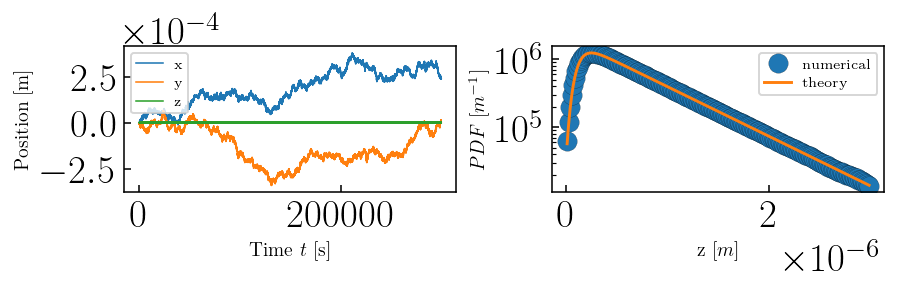

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(w,h/2))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
###################################################
fig.add_subplot(spec[0, 0])

plt.plot(langevin3D.t, langevin3D.x, linewidth=0.8, label="x")
plt.plot(langevin3D.t, langevin3D.y, linewidth=0.8, label="y")
plt.plot(langevin3D.t, langevin3D.z, linewidth=0.8, label="z")
plt.xlabel("Time $t$ [s]")
plt.ylabel("Position [m]")
plt.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))
plt.legend(loc="upper left", fontsize="x-small")

###################################################
fig.add_subplot(spec[0, 1])


axis = "z"
bins = 200
hist, bin_edges = np.histogram(langevin3D.z[langevin3D.z < 3e-6], bins=bins, density=True)
binsPosition = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_z = hist * 1/np.trapz(hist,binsPosition)

pdf_theo_brut = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
pdf_theo = pdf_theo_brut * 1/np.trapz(pdf_theo_brut,binsPosition) # normalised

plt.semilogy(binsPosition,pdf_z, "o", label="numerical")
plt.plot(binsPosition, pdf_theo, "-", label="theory")

plt.xlabel(axis + " $[m]$")
plt.ylabel("$PDF$ $[m^{-1}]$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend(fontsize="x-small")

# plt.savefig("RigidWall_Overdamped1.svg")

## PDF Delta z temps court et long 

Comme $D(z)$ dépend de la position $z$, alors la proba de déplacement $P(\Delta z)$ dépend de la distribution de $D_x(z)$, $D_y(z)$ et $D_z(z)$.

\begin{equation}
    P(\Delta x_i, \Delta t) = \frac{1}{N} \int_{0}^{+\infty}  P(D_i)~\exp \left ( -\frac{\Delta z^2}{4D_i \Delta t} \right )  \, \mathrm{d}D_i,
\end{equation}

où chaque point de l'espace a son propre $D_i$.

In [22]:
def gammax(z):
    xi = 1.5e-6 / (z+1.5e-6)

    return 6* np.pi* 1.5e-6* 0.001* (1- 9/16 * xi+ 1/8 * xi**3- 45/256 * xi**4 - 1/16 * xi**5)** (-1)


def pdf(data, bins = 50, density = True):
    #PDF(data)
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center 

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

##################################################
# Calcul théo de la PDF(Delta xi, Delta t) avec le mur -> D(z) non constant

def pdf_Di(axis="z"):
    """
    Calcul la PDF(Di)
    """
    z = np.linspace(1e-10, 10e-6, 1000)
    
    if axis == "z":
        Di = langevin3D.kb*langevin3D.T/langevin3D._gamma_z(z)
    
    else:
        Di = langevin3D.kb*langevin3D.T/gammax(z)
#         z = np.linspace(-10e-6, 10e-6, 1000)
        
    pdf_xi = P_z(z, 1, 4.8, langevin3D.lD, langevin3D.lB)
    return Di, Di*pdf_xi

def f_to_integrate(dz,n_dt, axis="z"):
    """
    Calcul de la fonction à intégrer pour 1 dt donnée
    """
    Di, PDi = pdf_Di(axis)
    f = PDi * 1/np.sqrt(4*np.pi*Di*n_dt*langevin3D.dt) * np.exp(-dz**2/(4*Di*n_dt*langevin3D.dt))

    return f, Di

def _pdf_DeltaXi_Delta_t(dz, n_dt, axis="z"):
    """
    Calcul de l'intégrale pour 1 Di.
    """
    f, Di = f_to_integrate(dz, n_dt, axis=axis)
    non_normalised = np.trapz(f, Di)
        
    return non_normalised

def pdf_DeltaXi_Delta_t(dz, n_dt, axis="z"):
    """
    Calcul de l'intégrale pour une liste Di.
    """
    A = 1
    Di = f_to_integrate(dz,n_dt, axis=axis)[1] #on récupère Di
    
    result = np.array([_pdf_DeltaXi_Delta_t(i, n_dt, axis=axis) for i in dz])
 
    
    #A = 1/np.trapz(result, dz)
    
    return A*result


Text(0.5, 0, '$\\Delta x/\\sigma$ ')

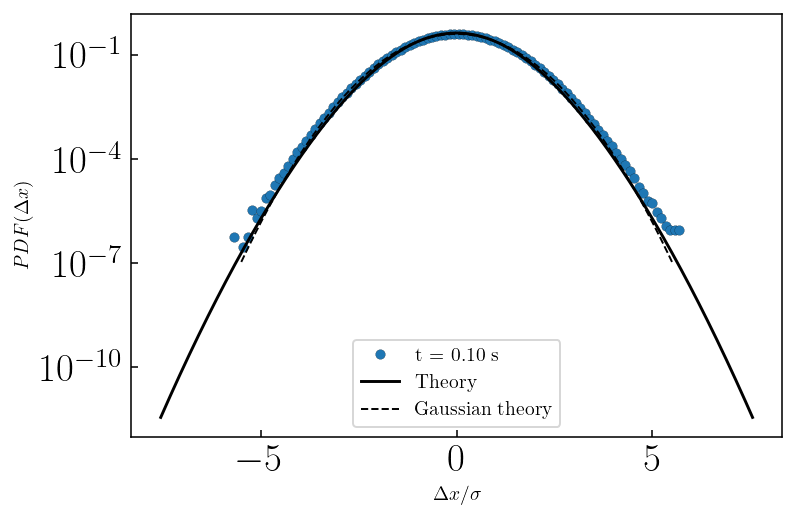

In [23]:
## PDF Dx (all time)

Di = pdf_Di(axis="x")[0]
dx = np.linspace(-10e-7, 10e-7, len(Di))

I = [10]

for i in I:
    
    Dezs = (langevin3D.x[0:-i] - langevin3D.x[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 100)
    plt.semilogy(bins_center, hist, ".",label = " t = {:.2f} s".format(langevin3D.t[i]))
    
    PDF_X =  langevin3D.P_deltaXi_shortTime(dx, i, "x", 1000, 4.8)
    plt.semilogy(dx/std, PDF_X/np.trapz(PDF_X, dx/std), "k", label="Theory")
    

    
x_theo = np.linspace(-5.5, 5.5, 1000)
gaussian_theo = gauss_function(x_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    
plt.semilogy(x_theo, gaussian_theo, "--", color="k",linewidth=1., label="Gaussian theory")
    
plt.legend()
plt.ylabel("$PDF(\Delta x)$")
plt.xlabel("$\Delta x/\sigma$ ") #($\mu m$)

Text(0.5, 0, '$\\Delta z/\\sigma$ ')

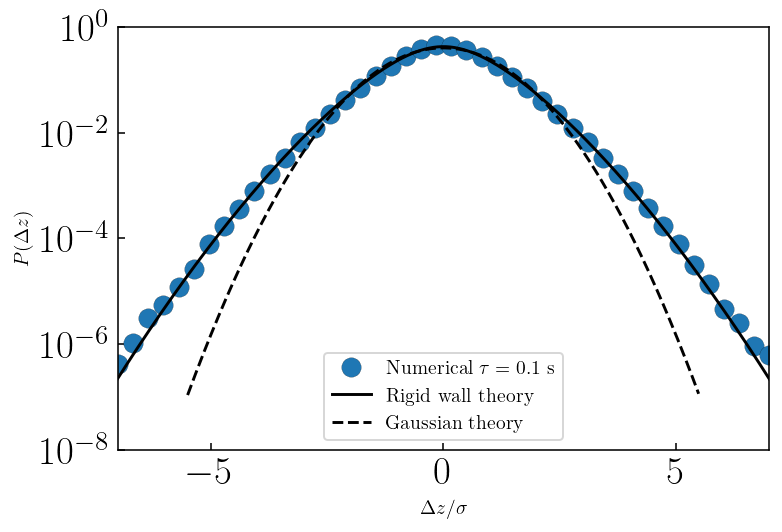

In [24]:
## PDF Dz SHORT TIME
I = [10]

Di = pdf_Di(axis="z")[0]
dz = np.linspace(-10e-7, 10e-7, len(Di))

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, "o",label =r"Numerical $\tau = "+ str(langevin3D.dt*i) + "~\mathrm{s}$")
    
    PDF =  pdf_DeltaXi_Delta_t(dz,i)
    plt.semilogy(dz/std,PDF/np.trapz(PDF,dz/std), "k", label=r"Rigid wall theory")
    

    
z_theo = np.arange(-5.5,5.5, 0.01)
gaussian_theo = gauss_function(z_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, z_theo)
    
plt.semilogy(z_theo, gaussian_theo, "--", color="black", label="Gaussian theory")


plt.xlim([-7, 7])
plt.ylim([1e-8, 1e0])

plt.legend()
plt.ylabel(r"$P(\Delta z)$")
plt.xlabel(r"$\Delta z/\sigma$ ")

(100.0, 1000000.0)

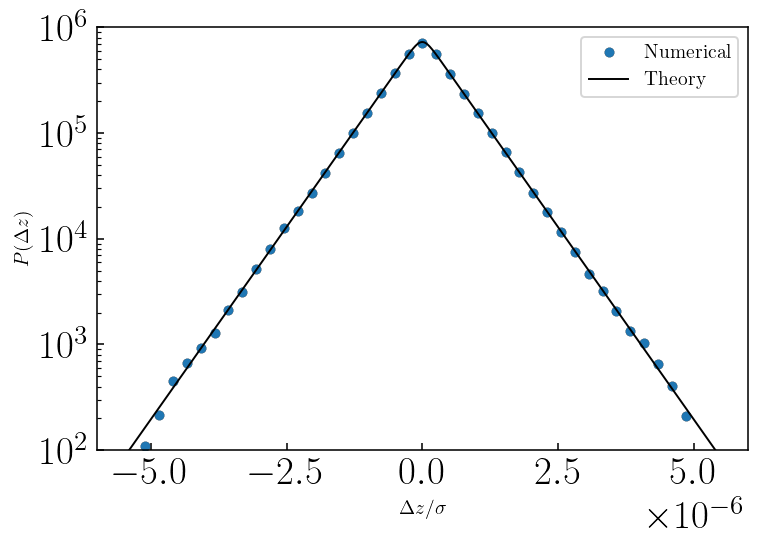

In [25]:
## PDF Dz LONG TIME
I = [5000]

Di = pdf_Di(axis="z")[0]
dz = np.linspace(-6e-6, 6e-6, len(Di))

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = 1#np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, ".",label = r"$\mathrm{Numerical}$")

    if i == I[-1]:
        PDF_theo_long = P_Deltaz_longTime(dz, 4, langevin3D.lD, langevin3D.lB)
        plt.semilogy(dz/std, 
                     PDF_theo_long / np.trapz(PDF_theo_long, dz/std), 
                     color="black", linewidth=1., label=r"Theory")
    

    
# z_theo = np.arange(-5.5,5.5, 0.01)
# gaussian_theo = gauss_function(z_theo, 1, 0, 1)
# gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, z_theo)
    
# plt.semilogy(z_theo, gaussian_theo, "--", color="red", linewidth=1., label="Gaussian theory")
    
plt.legend()
plt.ylabel(r"$P(\Delta z)$")
plt.xlabel(r"$\Delta z/\sigma$ ") #($\mu m$)
plt.xlim([-0.6e-5, 0.6e-5])
plt.ylim([1e2, 1e6])

## Plot joli pour rapport

In [26]:
Dpara_mean/langevin3D.D

0.579959543119282

In [27]:
# tau_c = langevin3D.lB*langevin3D.R / langevin3D.D

# N_tau = 10
# position = langevin3D.x
# bins = 100


# dX = position[N_tau:] - position[:-N_tau]

# hist, bin_edges = np.histogram(dX, bins=bins, density=True)
# binsPositions = (bin_edges[:-1] + bin_edges[1:]) / 2
# binsPositions = binsPositions / np.sqrt(2 * Dpara_mean * langevin3D.dt * N_tau)
# pdf = hist /N_tau np.trapz(hist, binsPosition)
# # z_theo = np.linspace(-5, 5, 1000)
# # PDFtheo = 1 / np.sqrt(2 * np.pi) * np.exp(-z_theo ** 2 / 2)
                      
# plt.semilogy(binsPositions, pdf, "o", label=r"$\mathrm{Numerical}$")
# # plt.plot(z_theo, PDFtheo, "k-", label=r"$\mathrm{Theoritical}$")

# plt.show()

In [28]:
def pdf(data, bins = 50, density = True):
    #PDF(data)
    
    pdf, bins_edge = np.histogram(data, bins = bins, density = density)
    bins_center = (bins_edge[0:-1] + bins_edge[1:]) / 2
    
    return pdf, bins_center 

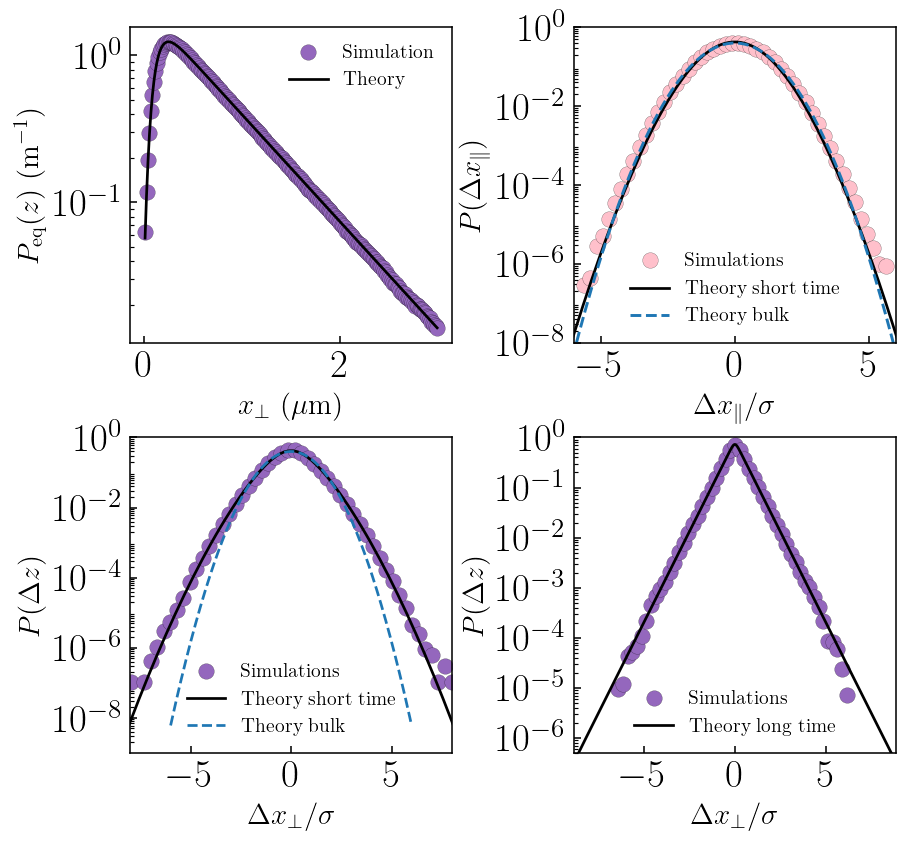

In [63]:
fig = plt.figure(figsize=(w, h*1.5), constrained_layout=False)
gs = fig.add_gridspec(2,2)

#### PDF_z

fig.add_subplot(gs[0, 0])

axis = "z"
bins = 200
hist, bin_edges = np.histogram(langevin3D.z[langevin3D.z < 3e-6], bins=bins, density=True)
binsPosition = ((bin_edges[:-1] + bin_edges[1:]) / 2)
pdf_z = hist * 1/np.trapz(hist,binsPosition*1e6)

pdf_theo_brut = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
pdf_theo = pdf_theo_brut * 1/np.trapz(pdf_theo_brut,binsPosition*1e6) # normalised

plt.semilogy(binsPosition*1e6,pdf_z, "o", color="tab:purple", markersize=8, label=r"Simulation")
plt.plot(binsPosition*1e6, pdf_theo, "-k", linewidth=1.4, label=r"Theory")

plt.xlabel(r"$x_\perp~ (\mu \mathrm{m})$", fontsize=15)
plt.ylabel(r"$P_\mathrm{eq}(z)~(\mathrm{m}^{-1})$", fontsize=15)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.legend(frameon=False)



###### SHORT TIME PDF X ###############################################################


fig.add_subplot(gs[0,1])


I = [10]

for i in I:
    
    Dezs = (langevin3D.x[0:-i] - langevin3D.x[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, "o", color="pink", markersize=8, label = r"Simulations")

dx_th= np.linspace(-100e-7, 100e-7, 1000)
PDF_theo_court =  pdf_DeltaXi_Delta_t(dx_th,I[0], "x")
plt.semilogy(dx_th/std, PDF_theo_court/np.trapz(PDF_theo_court,dx_th/std), color="black", linewidth=1.4, label=r"Theory short time")

    
x_theo = np.linspace(-7, 7, 1000)
gaussian_theo = gauss_function(x_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    
plt.semilogy(x_theo, gaussian_theo, "--", color="tab:blue", linewidth=1.5, label=r"Theory bulk")
    
plt.legend(frameon=False)
plt.ylabel(r"$ P(\Delta x_{\|})$", fontsize=15)
plt.xlabel(r"$\Delta x_{\|} / \sigma$ ", fontsize=15) #($\mu m$)

plt.xlim([-6, 6])
plt.ylim([1e-8, 1e0])

ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=100.0, subs=(1.0,), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())





####### SHORT TIME PDF Z ###############################################################

fig.add_subplot(gs[1,0])

#------> construction de la theorie temps court
Di = pdf_Di(axis="z")[0]
dz = np.linspace(-100e-7, 100e-7, len(Di))

I = [10]

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, "o", color="tab:purple", markersize=8, label = r"Simulations")
    
    PDF_theo_court =  pdf_DeltaXi_Delta_t(dz,i)
    plt.semilogy(dz/std, 
                     PDF_theo_court/np.trapz(PDF_theo_court,dz/std), 
                     color="black", linewidth=1.4, label=r"Theory short time")
    
z_theo = np.arange(-6, 6, 0.01)
gaussian_theo = gauss_function(z_theo, 1, 0, 1)
gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, z_theo)
    
plt.semilogy(z_theo, gaussian_theo, "--", linewidth=1.4, color="tab:blue", label=r"Theory bulk")

plt.xlim([-8, 8])
plt.ylim([1e-9, 1e0])

plt.legend(frameon=False)
plt.ylabel(r"$ P(\Delta z)$", fontsize=15)
plt.xlabel(r"$\Delta x_\perp / \sigma $ ", fontsize=15)

ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=100.0, subs=(1.0,), numticks=100)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


###### LONG TIME PDF Z ###############################################################


fig.add_subplot(gs[1,1])

I = [5000]

Di = pdf_Di(axis="z")[0]
dz = np.linspace(-9e-6, 9e-6, len(Di))

for i in I:
    
    Dezs = (langevin3D.z[0:-i] - langevin3D.z[i:])
    std = 1
    Dezs = Dezs #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center*1e6, hist/np.trapz(hist, bins_center*1e6), "o", color="tab:purple", markersize=8, label = r"Simulations")

    PDF_theo_long = P_Deltaz_longTime(dz, 4, langevin3D.lD, langevin3D.lB)
    plt.semilogy(dz*1e6, PDF_theo_long / np.trapz(PDF_theo_long, dz*1e6), color="black", linewidth=1.4, label=r"Theory long time")
    
plt.xlim([-8.8, 8.8])
plt.ylim([5e-7, 1e0])

plt.legend( frameon=False)
plt.ylabel(r"$P(\Delta z)$", fontsize=15)
plt.xlabel(r"$\Delta x_\perp / \sigma$", fontsize=15)

ax = plt.gca()
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0,), numticks=10)
ax.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

##########################
plt.tight_layout(pad = 0.01,h_pad=0.01, w_pad=0.3)



plt.savefig("RigidWall_Overdamped_VF.svg")

In [30]:
dx_th = [1e-9, 2e-9]
langevin3D.P_deltaXi_shortTime(dx_th,I[0], "x", 1000, 4.8)


array([1.00000010e+09, 9.99999901e+08])

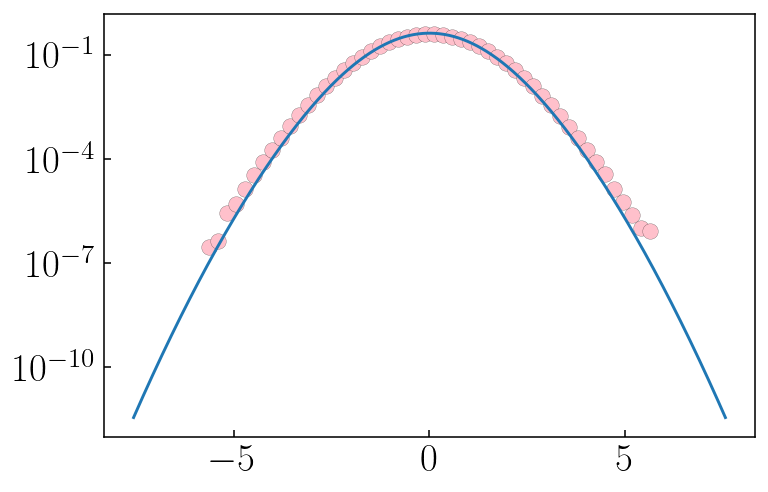

In [31]:
# Di = pdf_Di(axis="x")[0]
# dx = np.linspace(-7, 7, len(Di))

I = [10]

for i in I:
    
    Dezs = (langevin3D.x[0:-i] - langevin3D.x[i:])
    std = np.std(Dezs)
    Dezs = Dezs / std #division par standard déviation
    hist, bins_center = pdf(Dezs, bins = 50)
    plt.semilogy(bins_center, hist, "o", color="pink", markersize=8, label = r"$\Delta t$ = {:.2f} s".format(langevin3D.t[i]))

    
PDF_theo_court =  langevin3D.P_deltaXi_shortTime(dx,I[0], "x", 1000, 4.8)
plt.semilogy(dx/std, PDF_theo_court/np.trapz(PDF_theo_court,dx/std))#, color="black", linewidth=1.4, label=r"Rigid wall")

    
# x_theo = np.linspace(-7, 7, 1000)
# gaussian_theo = gauss_function(x_theo, 1, 0, 1)
# gaussian_theo = gaussian_theo * 1/np.trapz(gaussian_theo, x_theo)
    
# plt.semilogy(x_theo, gaussian_theo, "--", color="tab:blue", linewidth=1.5, label=r"Bulk")
    
# plt.legend(frameon=False)
# plt.ylabel(r"$ P(\Delta x_{\|})\sigma$", fontsize=10)
# plt.xlabel(r"$\frac{\Delta x_{\|}}{\sigma} $ ", fontsize=15) #($\mu m$)

# plt.xlim([-7, 7])

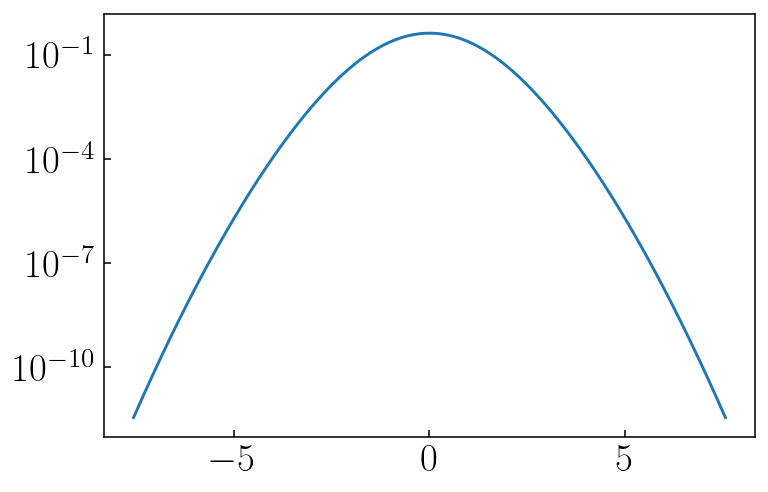

In [32]:
plt.semilogy(dx/std, PDF_theo_court/np.trapz(PDF_theo_court,dx/std))

In [33]:
PDF_theo_court =  langevin3D.P_deltaXi_shortTime(dx,I[0], "x", 1000, 4.8)


In [34]:
PDF_theo_court =  langevin3D.P_deltaXi_shortTime(dx_th,I[0], "x", 1000, 4.8)